# CHAPTER 2.4

### Implementing ResNet from scratch

RESNET architecture relies on a component called the residual module, which allows us to ensemble networks with depths that were unthinkable a couple of years ago. There are variants of ResNet that have more than 100 layers, without any loss of performance!
In here, we'll implement ResNet from scratch and train it on the challenging drop-in replacement to CIFAR-10, CINIC-10.

In [30]:
import os

import numpy as np
import tarfile
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import get_file

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
def residual_module(data,
                    filters,
                    stride,
                    reduce=False,
                    reg=0.0001,
                    bn_eps=2e-5,
                    bn_momentum=0.9):
    # The shortcut branch of the ResNet module should be
    # initialized as the input (identity) data
    shortcut = data

    # The first block of the Resnet module are the 1x1 CONVs
    bn_1 = BatchNormalization(axis=-1,
                              epsilon=bn_eps,
                              momentum=bn_momentum)(data)
    act_1 = ReLU()(bn_1)
    conv_1 = Conv2D(filters=int(filters / 4.),
                    kernel_size=(1, 1),
                    use_bias=False,
                    kernel_regularizer=l2(reg))(act_1)

    # ResNet's module second block are 3x3 convolutions.
    bn_2 = BatchNormalization(axis=-1,
                              epsilon=bn_eps,
                              momentum=bn_momentum)(conv_1)
    act_2 = ReLU()(bn_2)
    conv_2 = Conv2D(filters=int(filters / 4.),
                    kernel_size=(3, 3),
                    strides=stride,
                    padding='same',
                    use_bias=False,
                    kernel_regularizer=l2(reg))(act_2)

    # The third block of the ResNet module is another set of
    # 1x1 convolutions.
    bn_3 = BatchNormalization(axis=-1,
                              epsilon=bn_eps,
                              momentum=bn_momentum)(conv_2)
    act_3 = ReLU()(bn_3)
    conv_3 = Conv2D(filters=filters,
                    kernel_size=(1, 1),
                    use_bias=False,
                    kernel_regularizer=l2(reg))(act_3)

    # If we are to reduce the spatial size, apply a 1x1
    # convolution to the shortcut
    if reduce:
        shortcut = Conv2D(filters=filters,
                          kernel_size=(1, 1),
                          strides=stride,
                          use_bias=False,
                          kernel_regularizer=l2(reg))(act_1)

    x = Add()([conv_3, shortcut])

    return x

In [3]:
def build_resnet(input_shape,
                 classes,
                 stages,
                 filters,
                 reg=1e-3,
                 bn_eps=2e-5,
                 bn_momentum=0.9):
    inputs = Input(shape=input_shape)
    x = BatchNormalization(axis=-1,
                           epsilon=bn_eps,
                           momentum=bn_momentum)(inputs)

    x = Conv2D(filters[0], (3, 3),
               use_bias=False,
               padding='same',
               kernel_regularizer=l2(reg))(x)

    for i in range(len(stages)):
        # Initialize the stride, then apply a residual module
        # used to reduce the spatial size of the input volume.
        stride = (1, 1) if i == 0 else (2, 2)
        x = residual_module(data=x,
                            filters=filters[i + 1],
                            stride=stride,
                            reduce=True,
                            bn_eps=bn_eps,
                            bn_momentum=bn_momentum)

        # Loop over the number of layers in the stage.
        for j in range(stages[i] - 1):
            x = residual_module(data=x,
                                filters=filters[i + 1],
                                stride=(1, 1),
                                bn_eps=bn_eps,
                                bn_momentum=bn_momentum)

    x = BatchNormalization(axis=-1,
                           epsilon=bn_eps,
                           momentum=bn_momentum)(x)
    x = ReLU()(x)
    x = AveragePooling2D((8, 8))(x)

    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg))(x)
    x = Softmax()(x)

    return Model(inputs, x, name='resnet')

In [4]:
model = build_resnet(input_shape=(32, 32, 3),
                         classes=10,
                         stages=(9, 9, 9),
                         filters=(64, 64, 128, 256),
                         reg=5e-3)

In [5]:
print(model.summary())

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1728        ['batch_normalization[0][0]']    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 64)  256         ['conv2d[0][0]']            

In [31]:
from PIL import Image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='my_model_for_RESNET_6thnotebook.jpg')

In [6]:
def load_image_and_label(image_path, target_size=(32, 32)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, np.float32)
    image -= CINIC_MEAN_RGB  # Mean normalize
    image = tf.image.resize(image, target_size)

    label = tf.strings.split(image_path, os.path.sep)[-2]
    label = (label == CINIC_10_CLASSES)  # One-hot encode.
    label = tf.dtypes.cast(label, tf.float32)

    return image, label

We should define the mean RGB values of the CINIC-10 dataset, which is used in the load_image_and_label() function to mean normalize the images (this informationis available on the official CINIC-10 site

In [7]:
CINIC_MEAN_RGB = np.array([0.47889522, 0.47227842, 0.43047404])
CINIC_10_CLASSES = ['airplane', 'automobile', 'bird', 'cat',
                    'deer', 'dog', 'frog', 'horse', 'ship',
                    'truck']

In [8]:
data_directory='C:/Users/Zeki/.keras/datasets/cinic10'

In [9]:
train_pattern = os.path.sep.join(
    [data_directory, 'train/*/*.png'])
test_pattern = os.path.sep.join(
    [data_directory, 'test/*/*.png'])
valid_pattern = os.path.sep.join(
    [data_directory, 'valid/*/*.png'])

In [10]:
train_pattern

'C:/Users/Zeki/.keras/datasets/cinic10\\train/*/*.png'

In [13]:
def prepare_dataset(data_pattern, shuffle=False):
    dataset = (tf.data.Dataset
               .list_files(data_pattern)
               .map(load_image_and_label,
                    num_parallel_calls=AUTOTUNE)
               .batch(BATCH_SIZE))

    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)

    return dataset.prefetch(BATCH_SIZE)

In [14]:
BATCH_SIZE = 128
BUFFER_SIZE = 1024
train_dataset = prepare_dataset(train_pattern, shuffle=True)
test_dataset = prepare_dataset(test_pattern)
valid_dataset = prepare_dataset(valid_pattern)

In [19]:
len(train_dataset)

704

There are 9000 images for each class(10 classes) in every dataset.. 

In [20]:
len(test_dataset)

704

In [21]:
len(valid_dataset)

704

In [26]:
train_dataset

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [27]:
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [28]:
model_checkpoint_callback = ModelCheckpoint(filepath='./model.{epoch:02d}-{val_accuracy:.2f}.hdf5',
        save_weights_only=False,
        monitor='val_accuracy')

In [ ]:
EPOCHS = 100
model.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS,callbacks=[model_checkpoint_callback])

After each epoch, we save our model with its epoch number and validation accuracy

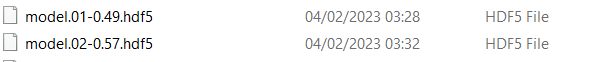

Each epoch takes about 4-5 mins on my computer... For time saving , I interrupt the kernel and will use a pretrained model...

In [32]:
model = load_model('model.38-0.72.hdf5')

In [33]:
result = model.evaluate(test_dataset)
print(f'Test accuracy: {result[1]}')

704/704 [==============================] - 83s 115ms/step - loss: 1.4183 - accuracy: 0.7196
Test accuracy: 0.7195666432380676


Without any data augmentation and transfer learning... % 72 can be a good result

In [34]:
result

[1.4183237552642822, 0.7195666432380676]